In [ ]:
import os

import keras

print("Keras = {}".format(keras.__version__))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import seaborn as sns
import pandas as pd


# Print gpus
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))



Keras = 3.6.0.dev2024101603
Num GPUs Available:  1


In [ ]:
model_dir = './models/'
model_file = model_dir + 'unetpp.keras'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ! unzip -o drive/MyDrive/dataset.zip

! pwd

/content


In [ ]:
# Data Directories
dir = "drive/MyDrive/dataset/chest_xray/"
train_dir = os.path.join(dir, 'train')
test_dir = os.path.join(dir, 'test')
val_dir = os.path.join(dir, 'val')


In [ ]:
data_distribution_count = pd.Series(
    {curr_index: len(os.listdir(os.path.join(train_dir, curr_index))) for curr_index in os.listdir(train_dir)})

data_distribution_count

NORMAL       1341
PNEUMONIA    3875
dtype: int64

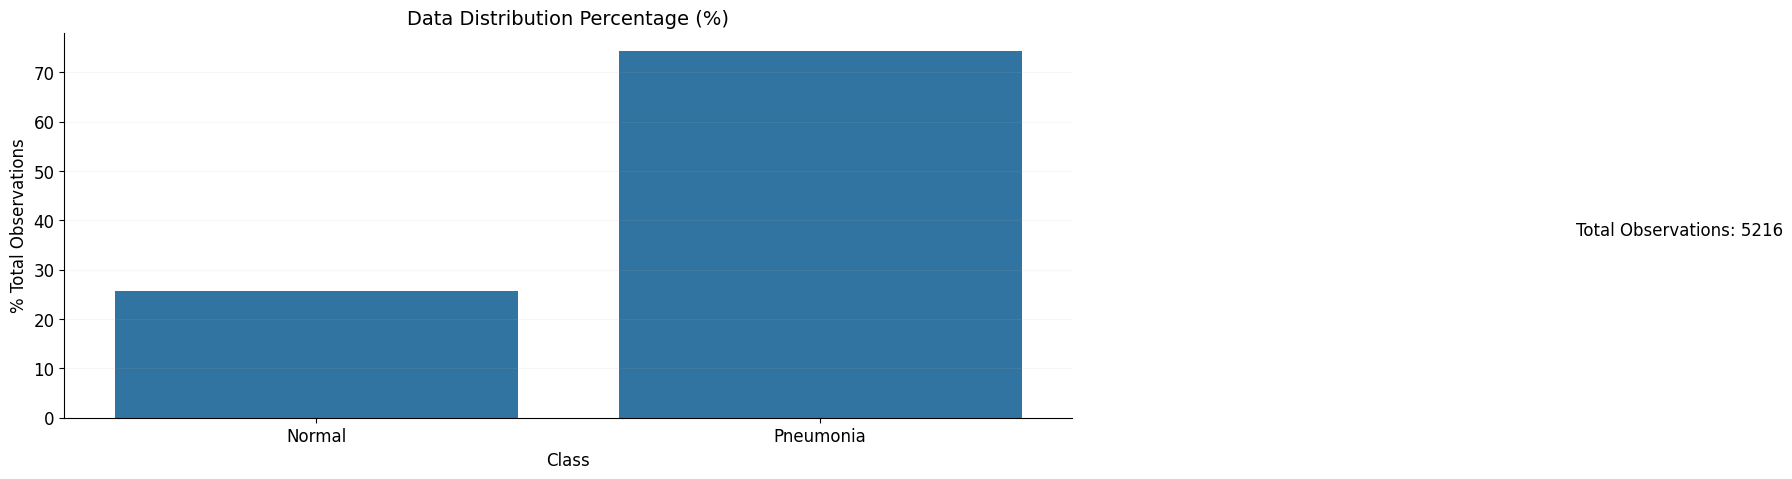

In [ ]:
fig, axis = plt.subplots(figsize=(13, 5))
axis.grid(True, alpha=0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize=14)
sns.barplot(x=['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index],
            y=100 * data_distribution_count / data_distribution_count.sum(), ax=axis)
axis.set_xlabel("Class", fontsize=12)
axis.set_ylabel("% Total Observations", fontsize=12)
axis.tick_params(which='major', labelsize=12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict=dict(size=12))
sns.despine()

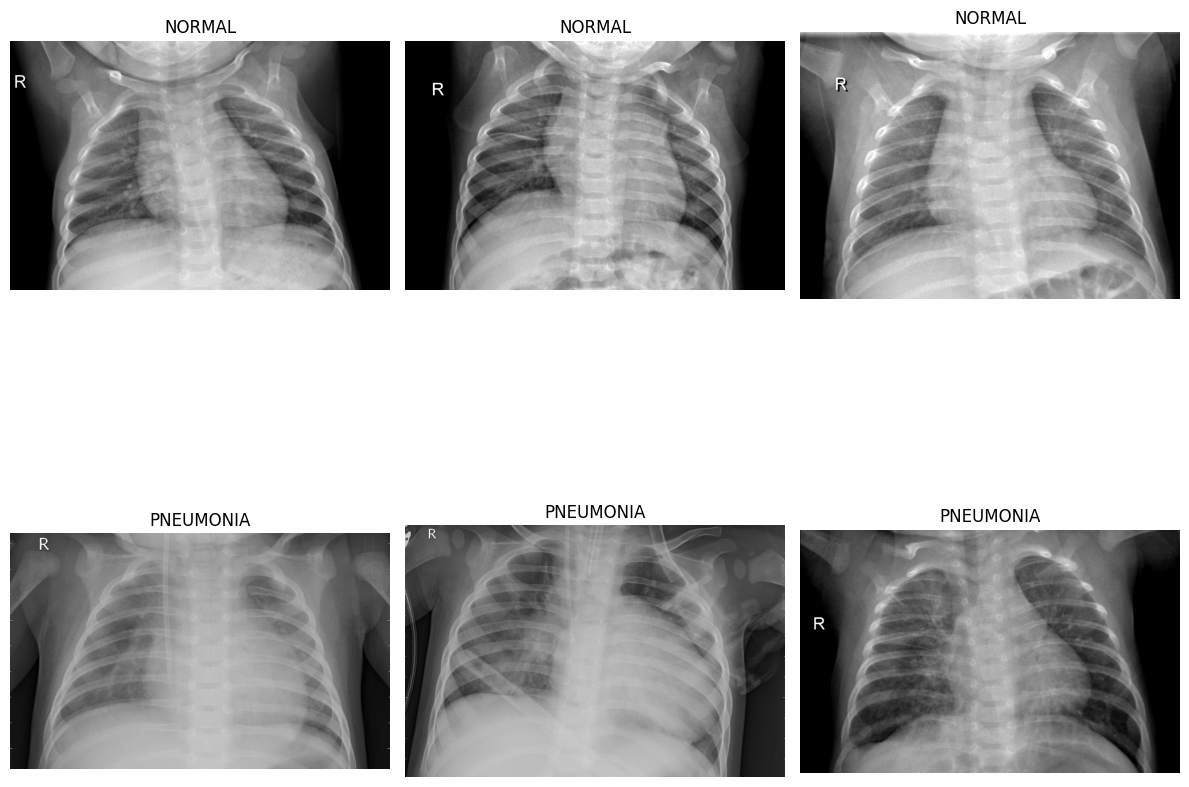

In [ ]:
# Display 12 images (3 from each class)
def display_images(directory):
    plt.figure(figsize=(12, 12))
    class_folders = os.listdir(directory)
    num_classes = len(class_folders)
    img_count_per_class = 3

    for i, class_name in enumerate(class_folders):
        class_path = os.path.join(directory, class_name)
        img_files = os.listdir(class_path)[:img_count_per_class]

        for j, img_file in enumerate(img_files):
            img_path = os.path.join(class_path, img_file)
            image = plt.imread(img_path)
            plt.subplot(num_classes, img_count_per_class, i * img_count_per_class + j + 1)
            plt.imshow(image, cmap='gray')
            plt.title(class_name)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display images
display_images(train_dir)

# Split Data

In [ ]:
classes = os.listdir(train_dir)

batch_size = 12

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    rotation_range=20,
    vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255,
                                  horizontal_flip=True,
                                  rotation_range=20,
                                  vertical_flip=True)

validation_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    seed=42,
    shuffle = False)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    seed=42,
    shuffle = False)

print(f'Train: {len(train_generator)}')
print(f'Test: {len(test_generator)}')
print(f'Validation: {len(validation_generator)}')
print(test_generator.class_indices)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Train: 435
Test: 52
Validation: 2
{'NORMAL': 0, 'PNEUMONIA': 1}


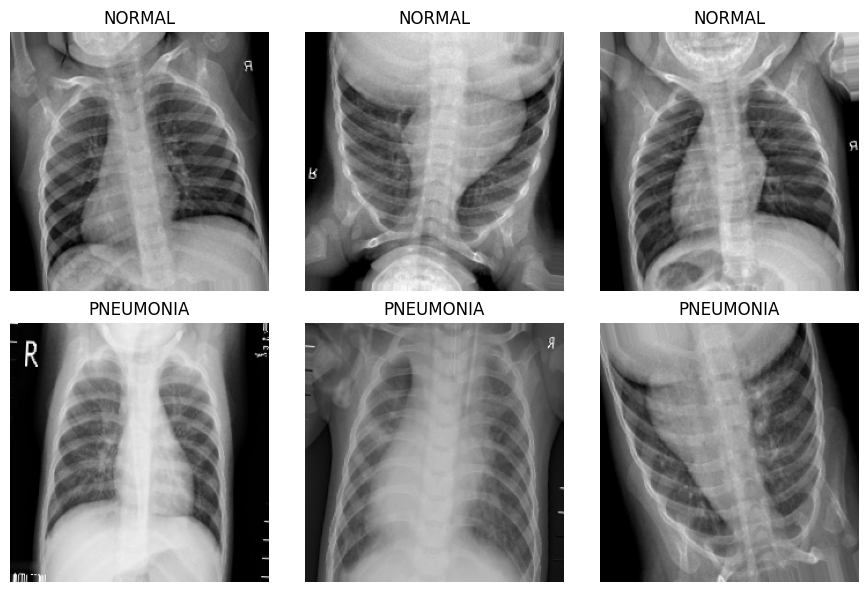

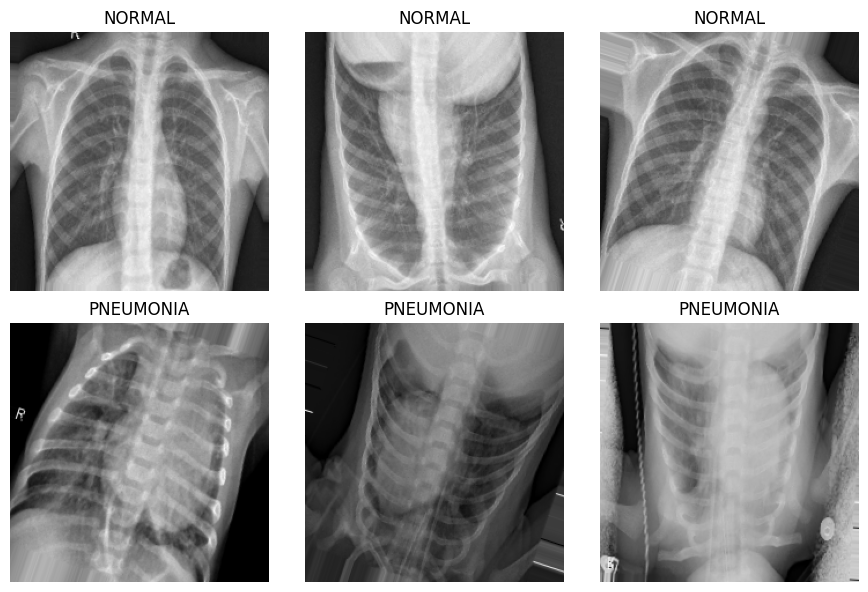

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images_from_generator(generator, num_images_per_class=3):
    # Get the class labels
    class_indices = generator.class_indices
    class_names = list(class_indices.keys())
    num_classes = len(class_names)

    # Initialize a dictionary to keep track of the images plotted for each class
    images_per_class = {class_name: 0 for class_name in class_names}

    # Prepare a figure for plotting
    fig, axes = plt.subplots(num_classes, num_images_per_class, figsize=(num_images_per_class*3, num_classes*3))

    # Ensure the axes array is always 2D
    if num_classes == 1:
        axes = np.expand_dims(axes, axis=0)

    if num_images_per_class == 1:
        axes = np.expand_dims(axes, axis=1)

    # Loop through batches of images from the generator
    for batch_x, batch_y in generator:
        for i in range(len(batch_x)):
            # Get the image and its corresponding label
            img = batch_x[i]
            label_index = np.argmax(batch_y[i])
            label_name = class_names[label_index]

            # Check if we have already plotted enough images for this class
            if images_per_class[label_name] < num_images_per_class:
                row = list(class_indices.keys()).index(label_name)
                col = images_per_class[label_name]
                axes[row, col].imshow(img)
                axes[row, col].axis('off')
                axes[row, col].set_title(label_name)

                # Update the count of images plotted for this class
                images_per_class[label_name] += 1

            # Check if we have enough images for all classes
            if all(count >= num_images_per_class for count in images_per_class.values()):
                break
        else:
            continue
        break

    plt.tight_layout()
    plt.show()

# Visualize images from the training generator
plot_images_from_generator(train_generator, num_images_per_class=3)

# Visualize images from the validation generator
plot_images_from_generator(test_generator, num_images_per_class=3)


In [ ]:
!pip install segmentation-models

In [ ]:
! pip install keras-nightly

In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

# import tensorflow
from tensorflow import keras
from segmentation_models import Unet
# from tensorflow.keras.regularizers import l2

# Model parameters
input_shape = (224, 224, 3)
num_classes = 2
initial_learning_rate = 1e-4

# Define the U-Net++ model
model = Unet('efficientnetb1', input_shape=input_shape, classes=num_classes, activation=None)
# tensorflow.keras.utils.plot_model(model, to_file='unetpp_model.png', show_shapes=True, show_layer_names=True)

# Add a GlobalAveragePooling2D layer to collapse spatial dimensions
model = keras.Sequential([
    model,
    keras.layers.GlobalAveragePooling2D()  # Pool across spatial dimensions
])

# Add a Dense layer with softmax activation for final classification
model.add(keras.layers.Dense(num_classes, activation='softmax'))

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()
# tf.keras.utils.plot_model(model, to_file='unetpp_model2.png', show_shapes=True, show_layer_names=True)


Segmentation Models: using `tf.keras` framework.
27164032/27164032 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional (Functional)              │ (None, 224, 224, 2)         │      12,641,314 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2)                   │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,641,320 (48.22 MB)

 Trainable params: 12,577,288 (47.98 MB)

 Non-trainable params: 64,032 (250.12 KB)

In [ ]:
from tensorflow.keras.callbacks import *
import math

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.3, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

train_samples = len(train_generator.filenames)
test_samples = len(test_generator.filenames)
validation_samples = len(validation_generator.filenames)

steps_per_epoch = math.ceil(train_samples / train_generator.batch_size)
validation_steps = math.ceil(validation_samples / validation_generator.batch_size)
test_steps = math.ceil(test_samples / test_generator.batch_size)

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")
print(f"Test steps: {test_steps}")

Steps per epoch: 435
Validation steps: 2
Test steps: 52


In [ ]:


# Train the model
history = model.fit(
    train_generator,
    # steps_per_epoch=steps_per_epoch,
    epochs=40,
    validation_data=test_generator,
    # validation_steps=validation_steps,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8642 - loss: 0.3997
Epoch 1: val_loss improved from inf to 1.09680, saving model to ./models/unetpp.keras
435/435 ━━━━━━━━━━━━━━━━━━━━ 2383s 5s/step - accuracy: 0.8644 - loss: 0.3994 - val_accuracy: 0.6282 - val_loss: 1.0968 - learning_rate: 1.0000e-04
Epoch 2/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9615 - loss: 0.1404
Epoch 2: val_loss improved from 1.09680 to 0.79540, saving model to ./models/unetpp.keras
435/435 ━━━━━━━━━━━━━━━━━━━━ 155s 356ms/step - accuracy: 0.9615 - loss: 0.1403 - val_accuracy: 0.7260 - val_loss: 0.7954 - learning_rate: 1.0000e-04
Epoch 3/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.9783 - loss: 0.0868
Epoch 3: val_loss improved from 0.79540 to 0.31420, saving model to ./models/unetpp.keras
435/435 ━━━━━━━━━━━━━━━━━━━━ 154s 353ms/step - accuracy: 0.9783 - loss: 0.0868 - val_accuracy: 0.8974 - val_loss: 0.3142 - learning_rate: 1.0000e-04
Epoch 4/40
435/435 ━━━━━━━━━

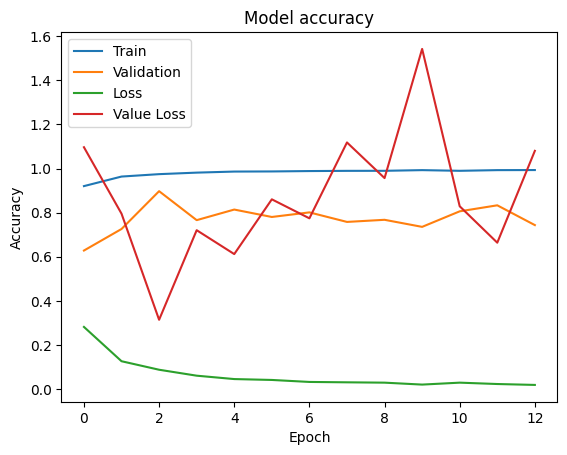

In [ ]:
# Learning curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation','Loss', 'Value Loss'], loc='upper left')
plt.show()

In [ ]:
# Validate the model with test data

model = keras.models.load_model(model_file)
model.evaluate(validation_generator)

2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 10s/step - accuracy: 1.0000 - loss: 0.0844


[0.10273435711860657, 1.0]

2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 10s/step


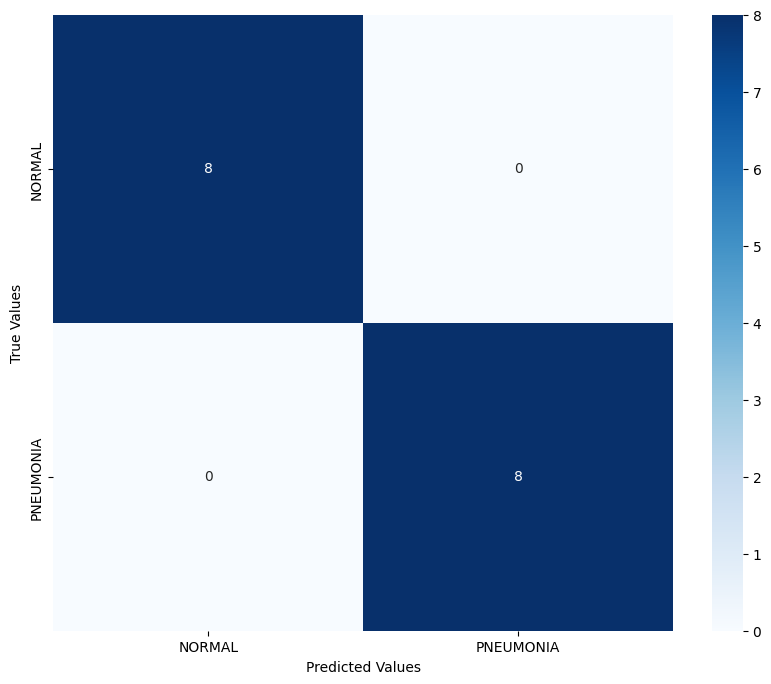

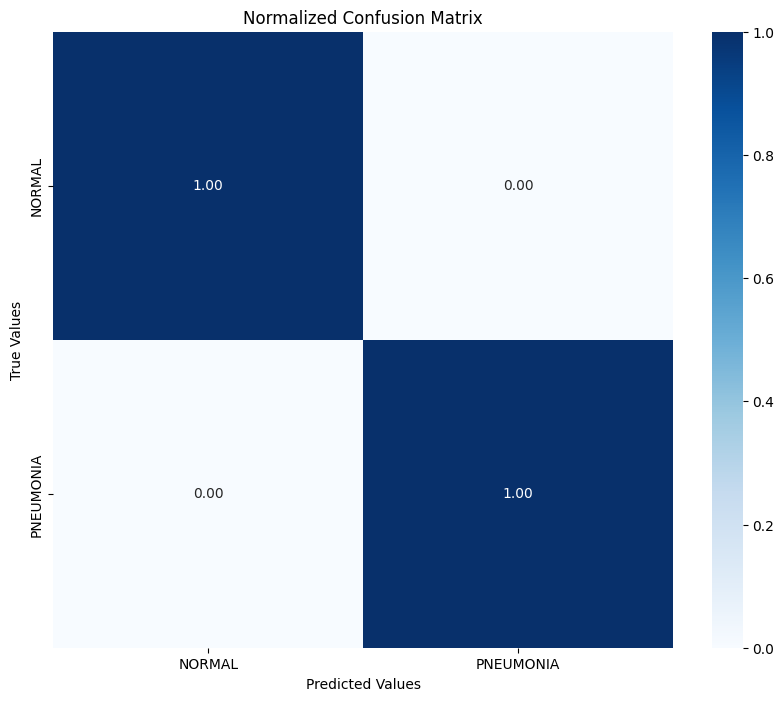

DSC: 1.0, Sensitivity: 1.0, Specificity: 1.0, Accuracy: 1.0


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

classes = ['NORMAL', 'PNEUMONIA']

def calculate_metrics(y_true, y_pred):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.show()

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the normalized confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.title('Normalized Confusion Matrix')
    plt.show()

    # Calculate metrics for each class and average them
    dsc = np.mean([2.0 * cm[i, i] / (np.sum(cm[i, :]) + np.sum(cm[:, i])) for i in range(cm.shape[0])])
    sensitivity = np.mean([cm[i, i] / np.sum(cm[i, :]) for i in range(cm.shape[0])])
    specificity = np.mean([np.sum(np.delete(np.delete(cm, j, 0), j, 1)) / np.sum(np.delete(cm, j, 0)) for j in range(cm.shape[0])])

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    return dsc, sensitivity, specificity, accuracy

# Predict the output
predictions_prob = model.predict(validation_generator)
predictions = np.argmax(predictions_prob, axis=1)

dsc, sensitivity, specificity, accuracy = calculate_metrics(validation_generator.classes, predictions)
print(f"DSC: {dsc}, Sensitivity: {sensitivity}, Specificity: {specificity}, Accuracy: {accuracy}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


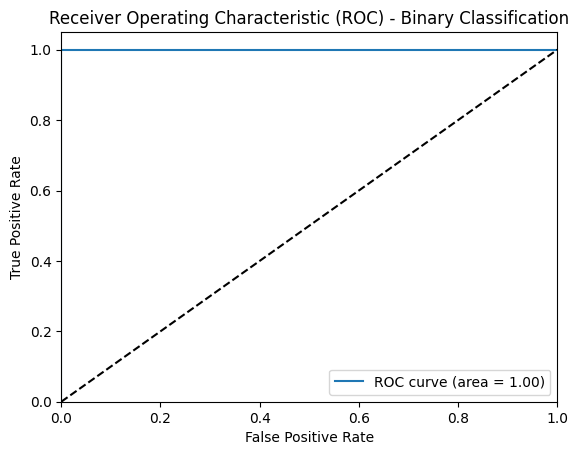

              precision    recall  f1-score   support

      NORMAL       1.00      1.00      1.00         8
   PNEUMONIA       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



In [ ]:
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import numpy as np

# Binarize the output
lb = LabelBinarizer()
y_test = lb.fit_transform(validation_generator.classes)
y_pred = lb.transform(predictions)
classes = ['NORMAL', 'PNEUMONIA']

# For binary classification, predictions_prob should have shape (n_samples, 1)
# y_test = validation_generator.classes  # Assuming binary labels (0 or 1)
y_test = validation_generator.classes.reshape(-1, 1)  # Reshape to (n_samples, 1)

# Predict the output
predictions_prob_og = model.predict(validation_generator, steps=validation_steps)

# Compute ROC curve and ROC area for the positive class (e.g., PNEUMONIA)
predictions_prob = predictions_prob_og[:, 1]  # Take the probability of the positive class
fpr, tpr, _ = roc_curve(y_test, predictions_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Binary Classification')
plt.legend(loc="lower right")
plt.show()

# Print classification report
y_pred = np.argmax(predictions_prob_og, axis=1)
print(classification_report(y_test, y_pred, target_names=classes))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step 


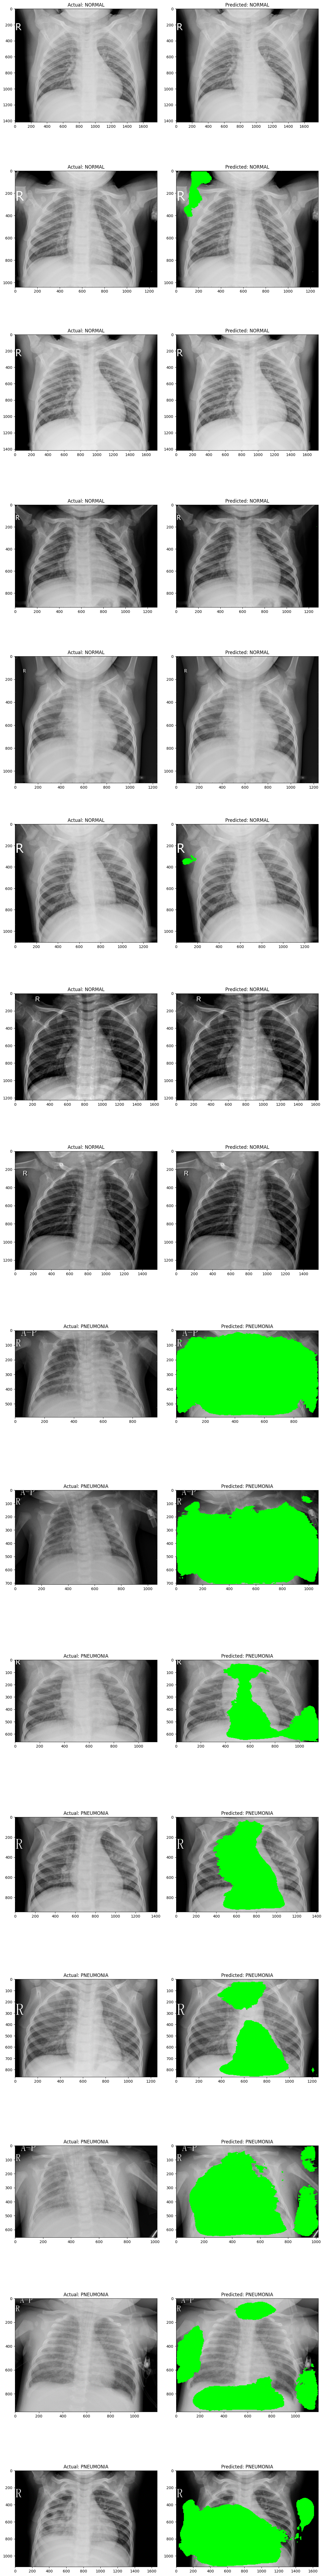

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Define the class names
classes = ['NORMAL', 'PNEUMONIA']

# Get predictions from the model
predictions_model_2 = model.layers[0].predict(validation_generator)
predictions_prob = model.predict(validation_generator)
predictions = np.argmax(predictions_prob, axis=1)

# Thresholding
threshold = 0.90  # Adjust threshold as needed for binary mask (if needed)
binary_mask = (predictions_model_2 > threshold).astype(np.uint8)

# Track displayed classes and their counts
displayed_classes_counts = {class_name: 0 for class_name in classes}

# Set maximum number of images to display per class
num_images_per_class = 8

# Total number of images in the validation directory
total_images = len(validation_generator.filenames)

# Prepare to display the images
plt.figure(figsize=(12, 6 * len(classes) * num_images_per_class))
image_index = 0

# Iterate through the images
for i in range(total_images):
    # Get the actual class index and name
    actual_class_index = validation_generator.classes[i]
    actual_class_name = classes[actual_class_index]

    # Check if we have already displayed the required number of images for this class
    if displayed_classes_counts[actual_class_name] >= num_images_per_class:
        continue

    # Load original image using generator path
    img_path = os.path.join(val_dir, validation_generator.filenames[i])
    original_image = cv2.imread(img_path)

    # Check if the image is loaded correctly
    if original_image is None:
        print(f"Warning: Image at path {img_path} could not be loaded.")
        continue

    # Convert the original image to RGB
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Resize the binary mask to match the shape of the original image
    reshaped_binary_mask = cv2.resize(binary_mask[i][:, :, 0], (original_image_rgb.shape[1], original_image_rgb.shape[0]))

    # Overlay mask on original image
    overlay = original_image_rgb.copy()
    overlay[reshaped_binary_mask == 1] = (0, 255, 0)  # Overlay mask in green color

    # Get predicted class name
    predicted_class_name = classes[predictions[i]]

    # Plot original image with overlayed mask
    plt.subplot(len(classes) * num_images_per_class, 2, 2 * image_index + 1)
    plt.imshow(original_image_rgb)
    plt.title(f'Actual: {actual_class_name}')

    plt.subplot(len(classes) * num_images_per_class, 2, 2 * image_index + 2)
    plt.imshow(overlay)
    plt.title(f'Predicted: {predicted_class_name}')

    # Mark this class as displayed
    displayed_classes_counts[actual_class_name] += 1
    image_index += 1

    # Break the loop if we've displayed the required number of images for all classes
    if all(count >= num_images_per_class for count in displayed_classes_counts.values()):
        break

plt.tight_layout()
plt.show()
